In [1]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Efficiency data

In [2]:
df = pd.read_hdf(project_dir / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
28000,1,124.238854,58.453561,Co60,0
28001,1,113.094937,54.431677,Co60,1
28002,1,121.327974,56.307965,Co60,2
28003,1,100.402556,52.775469,Co60,3
28004,1,107.285256,59.279207,Co60,4
...,...,...,...,...,...
18995,19,139.922830,59.237333,proton,995
18996,19,142.927215,56.372274,proton,996
18997,19,152.816456,59.454838,proton,997
18998,19,125.063492,57.718604,proton,998


In [3]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                       
Co60      1       114.387380   7.033251
          2       118.898435   3.335347
          3       118.691161   8.413698
          4       120.421177  10.888093
          5       120.977444   6.778038
          6       126.199828   6.721238
          7       124.525337   5.199584
          8       115.523631   4.536485
          9       120.390567   5.347824
          10      127.348490   6.566576
          11      122.941147   4.955011
          12      119.014334   5.472272
          13      124.039371   6.808802
          14      122.554757   3.930798
          15      121.954616   5.566625
          17      125.528894   7.339324
          18      118.908995   4.427625
          19      118.680668   7.009576
proton    1       111.129133   6.882062
          2       117.587757   3.789052
          3       121.791685   4.426034
          4       120.315540  10.179805
          5       119.888834   6.543474
          6       216.654728  11.219255
          7       221.809959   8.921396
          8       219.493976   7.152641
          9       234.363354  10.313298
          10      261.391740  13.922004
          11      267.442440  10.241222
          12      271.940998  12.693457
          13      304.461897  17.553427
          14      313.276834  10.574676
          15      353.942478  18.077884
          16      392.919978  21.575560
          17      452.595596  26.812165
          18      502.196779  23.684695
          19      131.028714   8.220223

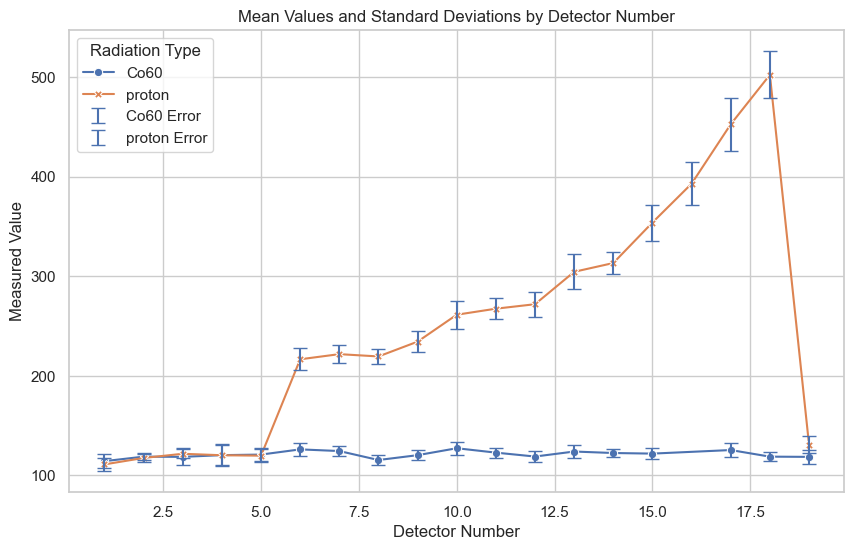

In [4]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [5]:
df_bp_exp = pd.read_hdf(project_dir / 'data' / 'raw' / 'article-plots.h5', key='bp_exp')
df_bp_mc = pd.read_hdf(project_dir / 'data' / 'raw' / 'article-plots.h5', key='bp_mc')

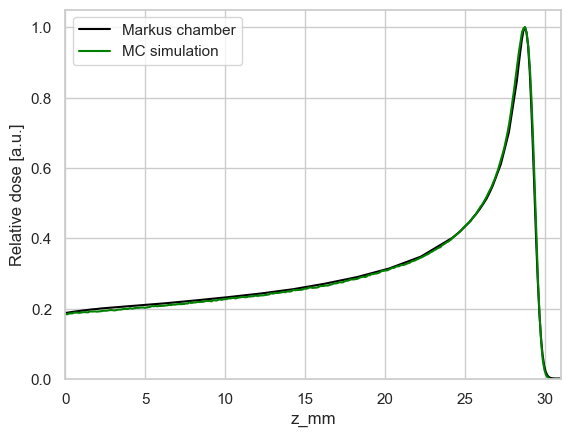

In [6]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [7]:
df_pos = pd.read_excel(project_dir / 'data' / 'raw' / 'foils_phantom.xlsx', 
sheet_name='Arkusz1', 
skiprows=6, 
nrows=32, 
usecols="A,D:E",
names=["det_no", "det_thick", "det_end"])
# drop row no 5
df_pos.drop(5, inplace=True)
df_pos['det_begin'] = df_pos.det_end - df_pos.det_thick
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos

,det_no,det_thick,det_end,det_begin,det_mid
0,1,0.44935,0.449350,0.000000,0.224675
1,2,0.44935,0.898700,0.449350,0.674025
2,3,0.44935,1.348050,0.898700,1.123375
3,4,0.44935,1.797400,1.348050,1.572725
4,5,0.44935,2.246750,1.797400,2.022075
6,6,0.44935,20.905925,20.456575,20.681250
7,7,0.44935,21.355275,20.905925,21.130600
8,8,0.44935,21.804625,21.355275,21.579950
9,9,0.44935,22.253975,21.804625,22.029300
10,10,0.44935,22.703325,22.253975,22.478650


In [8]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,det_end,det_begin,det_mid
0,Co60,1,114.387380,7.033251,0.44935,0.449350,0.000000,0.224675
1,Co60,2,118.898435,3.335347,0.44935,0.898700,0.449350,0.674025
2,Co60,3,118.691161,8.413698,0.44935,1.348050,0.898700,1.123375
3,Co60,4,120.421177,10.888093,0.44935,1.797400,1.348050,1.572725
4,Co60,5,120.977444,6.778038,0.44935,2.246750,1.797400,2.022075
5,Co60,6,126.199828,6.721238,0.44935,20.905925,20.456575,20.681250
6,Co60,7,124.525337,5.199584,0.44935,21.355275,20.905925,21.130600
7,Co60,8,115.523631,4.536485,0.44935,21.804625,21.355275,21.579950
8,Co60,9,120.390567,5.347824,0.44935,22.253975,21.804625,22.029300
9,Co60,10,127.348490,6.566576,0.44935,22.703325,22.253975,22.478650


(0.0, 30.0)

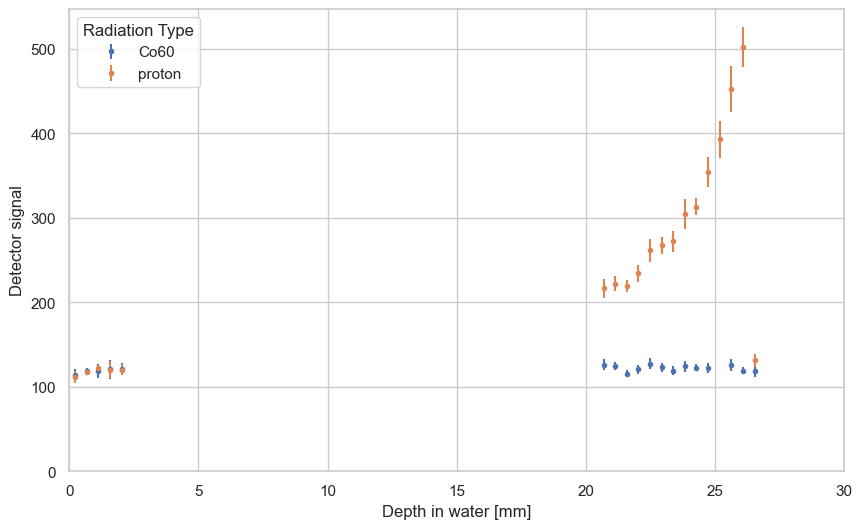

In [9]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [10]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [11]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [12]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [13]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 5
dose_Co60 = 5
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [14]:
df_reset_pos['mean_signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos['std_signal_per_Gy'] = df_reset_pos['std'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,det_end,det_begin,det_mid,dose,mean_signal_per_Gy,std_signal_per_Gy
0,Co60,1,114.387380,7.033251,0.44935,0.449350,0.000000,0.224675,5.000000,22.877476,1.406650
1,Co60,2,118.898435,3.335347,0.44935,0.898700,0.449350,0.674025,5.000000,23.779687,0.667069
2,Co60,3,118.691161,8.413698,0.44935,1.348050,0.898700,1.123375,5.000000,23.738232,1.682740
3,Co60,4,120.421177,10.888093,0.44935,1.797400,1.348050,1.572725,5.000000,24.084235,2.177619
4,Co60,5,120.977444,6.778038,0.44935,2.246750,1.797400,2.022075,5.000000,24.195489,1.355608
5,Co60,6,126.199828,6.721238,0.44935,20.905925,20.456575,20.681250,5.000000,25.239966,1.344248
6,Co60,7,124.525337,5.199584,0.44935,21.355275,20.905925,21.130600,5.000000,24.905067,1.039917
7,Co60,8,115.523631,4.536485,0.44935,21.804625,21.355275,21.579950,5.000000,23.104726,0.907297
8,Co60,9,120.390567,5.347824,0.44935,22.253975,21.804625,22.029300,5.000000,24.078113,1.069565
9,Co60,10,127.348490,6.566576,0.44935,22.703325,22.253975,22.478650,5.000000,25.469698,1.313315


(0.0, 30.0)

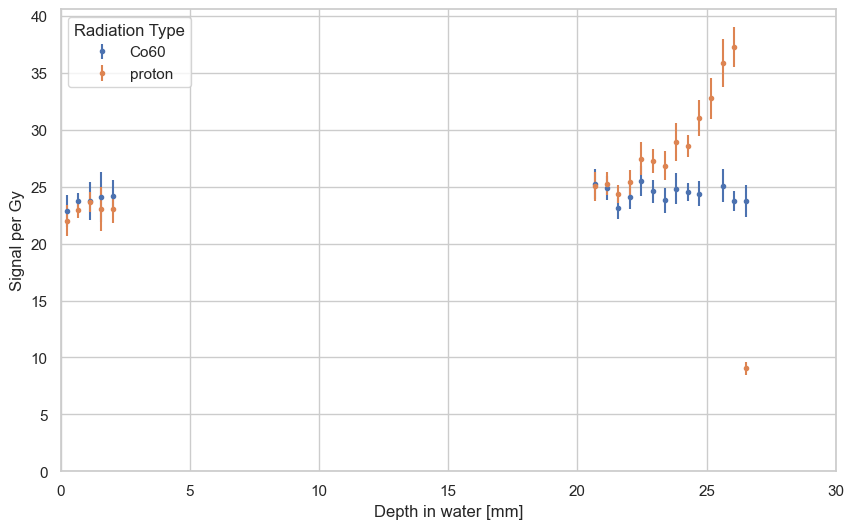

In [15]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean_signal_per_Gy'], yerr=subset['std_signal_per_Gy'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [16]:
co60_data = df_reset_pos.loc[df_reset_pos.radiation == 'Co60']
proton_data = df_reset_pos.loc[df_reset_pos.radiation == 'proton']
all_data = co60_data.merge(proton_data, on='det_no', suffixes=['_Co60', '_proton'])
all_data['mean_efficiency'] = all_data['mean_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
numerator_relative_std = all_data['std_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
denominator_term = all_data['mean_signal_per_Gy_proton'] * all_data['std_signal_per_Gy_Co60'] / (all_data['mean_signal_per_Gy_Co60']**2)
all_data['std_efficiency'] = numerator_relative_std + denominator_term

(0.0, 30.0)

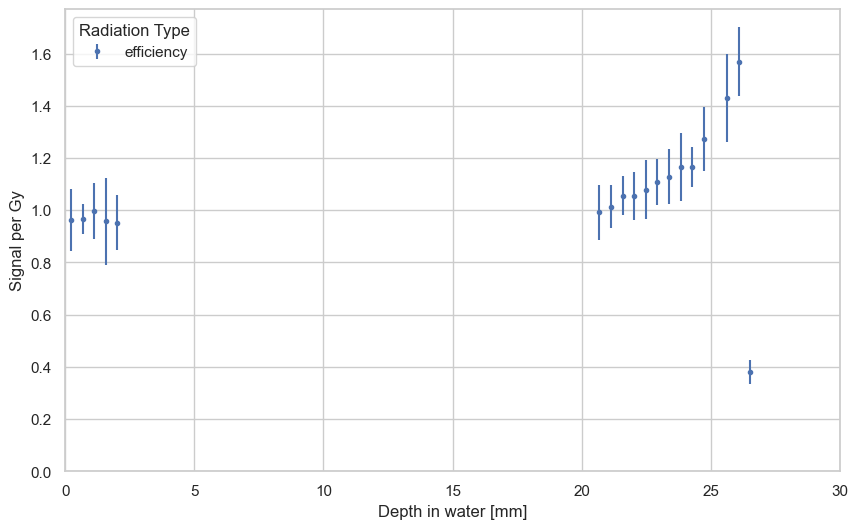

In [17]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
plt.errorbar(all_data['det_mid_proton'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)